## Bike Sharing Assignment

#### Problem Statement:

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 


In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.
They want to understand the factors affecting the demand for these shared bikes in the American market.


#### Business Goals:

The company wants to know:
1. Which variables are significant in predicting the demand for shared bikes.
2. How well those variables describe the bike demands


#### Steps:

   1. Reading, understanding the data
   2. Visualizing the data
   3. Data Preparation
   4. Splitting the Data into Training and Testing Set
   5. Building the model
   6. Train the model - Reduce the predictors based on vif and p-value itertatively
   7. Residual analysis of the train data
   8. Making Predictions Using the Final Model on the test data
   9. Model Evaluation


## Step 1: Reading, understanding the data

In [1]:
# Importing all required packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import datetime
from scipy.stats import pearsonr
%matplotlib inline

In [2]:
## Generic Functions

# Method to get Meta-Data about any dataframe passed 
def getMetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes, # data types of columns
                    'Total_Element': dataframe.count(), # total elements in columns
                    'Null_Count': dataframe.isnull().sum(), # total null values in columns
                    'Null_Percentage': round(dataframe.isnull().sum()/len(dataframe) * 100,2) ,# percentage of null values
                    'Unique_Value': dataframe.nunique()
                       })
    return metadata_matrix

def getVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def binary_map(x):
    return x.map({'yes': 1, "no": 0})

In [3]:
bike_df=pd.read_csv('day.csv')
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Inspect the various aspects of the housing dataframe

In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
bike_df.shape

(730, 16)

In [6]:
bike_metadata=getMetadata(bike_df)
bike_metadata

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
instant,int64,730,0,0.0,730
dteday,object,730,0,0.0,730
season,int64,730,0,0.0,4
yr,int64,730,0,0.0,2
mnth,int64,730,0,0.0,12
holiday,int64,730,0,0.0,2
weekday,int64,730,0,0.0,7
workingday,int64,730,0,0.0,2
weathersit,int64,730,0,0.0,3
temp,float64,730,0,0.0,498


<font color='green'/>**Analysis** - No Null Records

#### Drop the redundant Columns:
    1. Instant: Its an index column
    2. Dteday: Year and month are already given in seperate field(yr and month)
    3. Casual and Registered: As stated in the documentation, casual+registered=cnt and cnt is our target variable

In [7]:
col_to_drop=['instant','dteday','registered','casual']
bike_df.drop(col_to_drop,axis=1,inplace=True)

In [8]:
bike_metadata=getMetadata(bike_df)
bike_metadata

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
season,int64,730,0,0.0,4
yr,int64,730,0,0.0,2
mnth,int64,730,0,0.0,12
holiday,int64,730,0,0.0,2
weekday,int64,730,0,0.0,7
workingday,int64,730,0,0.0,2
weathersit,int64,730,0,0.0,3
temp,float64,730,0,0.0,498
atemp,float64,730,0,0.0,689
hum,float64,730,0,0.0,594


#### Populating the categorical columns with correct mapping

In [9]:
bike_df['season'].replace({1:"spring",2:"summer",3:"fall",4:"winter"},inplace=True)
bike_df['season'].value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [10]:
bike_df['yr'].replace({0:"2018",1:"2019"},inplace=True)
bike_df['yr'].value_counts()

2018    365
2019    365
Name: yr, dtype: int64

In [11]:
bike_df['weathersit'].replace({1:"clear",2:"mist",3:"light",4:"heavy"},inplace=True)
bike_df['weathersit'].value_counts()

clear    463
mist     246
light     21
Name: weathersit, dtype: int64

In [12]:
bike_df[(bike_df.workingday==0)]["weekday"].value_counts()

0    105
6    105
1     15
4      2
5      2
2      1
3      1
Name: weekday, dtype: int64

<font color='green'/>**Analysis** - Based on it, its fair to assume week starts on Sunday

In [13]:
bike_df['weekday'].replace({0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"},inplace=True)
bike_df.head(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,1,0,Saturday,0,mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,1,0,Sunday,0,mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,1,0,Monday,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,1,0,Tuesday,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,1,0,Wednesday,1,clear,9.305237,11.46350,43.6957,12.522300,1600
5,spring,2018,1,0,Thursday,1,clear,8.378268,11.66045,51.8261,6.000868,1606
6,spring,2018,1,0,Friday,1,mist,8.057402,10.44195,49.8696,11.304642,1510
7,spring,2018,1,0,Saturday,0,mist,6.765000,8.11270,53.5833,17.875868,959
8,spring,2018,1,0,Sunday,0,clear,5.671653,5.80875,43.4167,24.250650,822
9,spring,2018,1,0,Monday,1,clear,6.184153,7.54440,48.2917,14.958889,1321


In [14]:
bike_df['mnth'].replace({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
                         7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
                        ,inplace=True)
bike_df["mnth"].value_counts()

Jul    62
Dec    62
Oct    62
Aug    62
Jan    62
Mar    62
May    62
Jun    60
Sep    60
Nov    60
Apr    60
Feb    56
Name: mnth, dtype: int64

In [15]:
bike_metadata=getMetadata(bike_df)
bike_metadata

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
season,object,730,0,0.0,4
yr,object,730,0,0.0,2
mnth,object,730,0,0.0,12
holiday,int64,730,0,0.0,2
weekday,object,730,0,0.0,7
workingday,int64,730,0,0.0,2
weathersit,object,730,0,0.0,3
temp,float64,730,0,0.0,498
atemp,float64,730,0,0.0,689
hum,float64,730,0,0.0,594


In [16]:
bike_df.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,4508.006849
std,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,1936.011647
min,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


In [17]:
bike_df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Saturday,0,mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Sunday,0,mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Monday,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Tuesday,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Wednesday,1,clear,9.305237,11.46350,43.6957,12.522300,1600


## Step 2: Visualizing the data

#### Visualising Numeric Variables

Let's make a pairplot of all the numeric variables

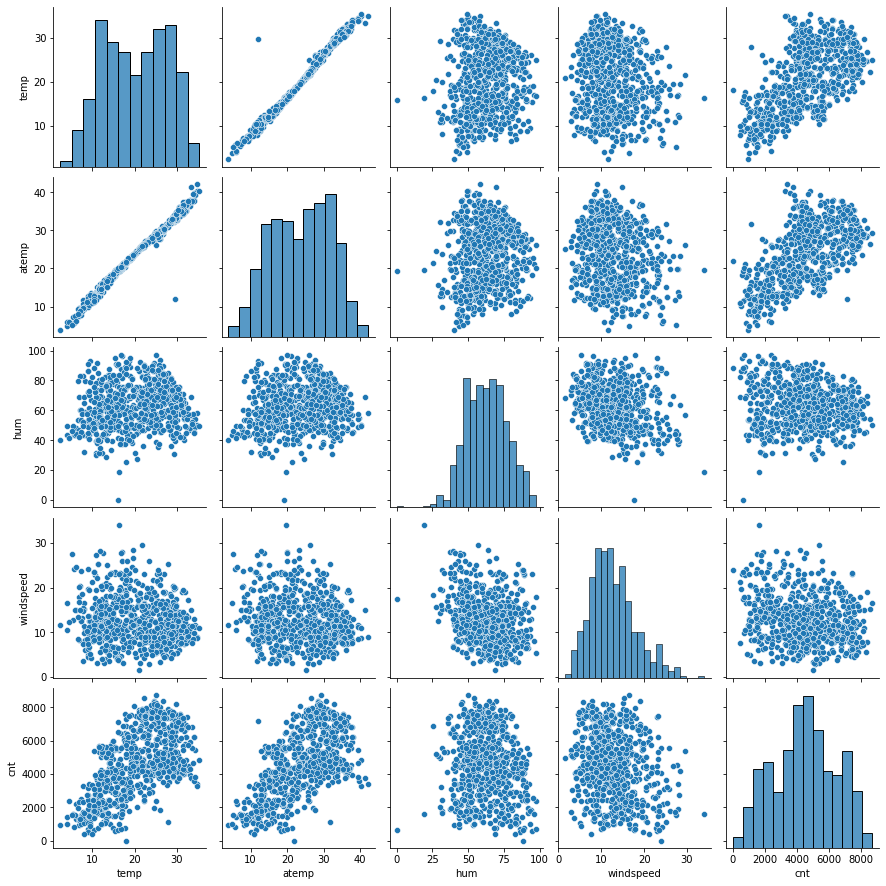

In [18]:
num_list=['temp','atemp','hum','windspeed','cnt']
sns.pairplot(data=bike_df,vars=num_list)
plt.show()

<font color='green'/>**Analysis** - Based on the pairplot, temp and atemp have high correlation

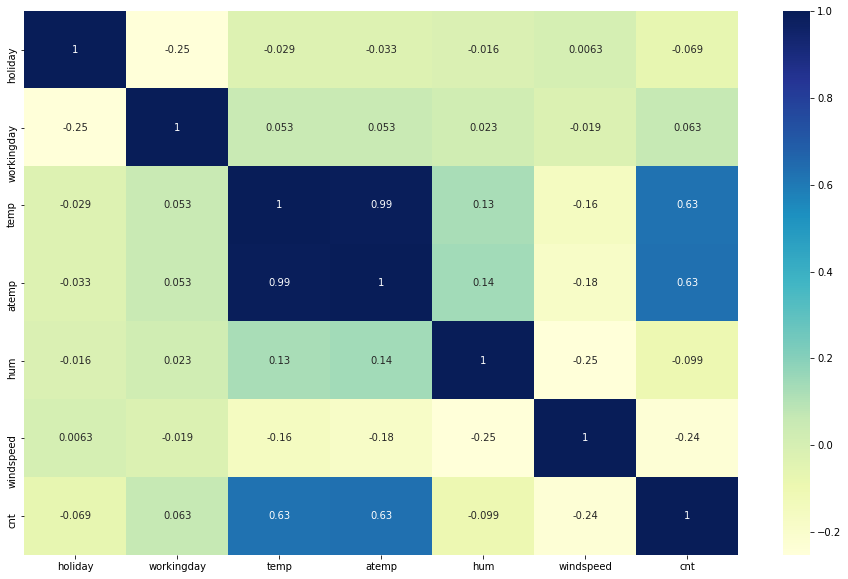

In [19]:
plt.figure(figsize = (16, 10))
sns.heatmap(bike_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

<font color='green'/>**Analysis** - Based on the heatmap, temp and atemp have high correlation with 0.99. Hence dropping one of the column

In [20]:
bike_df.drop(['temp'],axis=1,inplace=True)
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Saturday,0,mist,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Sunday,0,mist,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Monday,1,clear,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Tuesday,1,clear,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Wednesday,1,clear,11.46350,43.6957,12.522300,1600


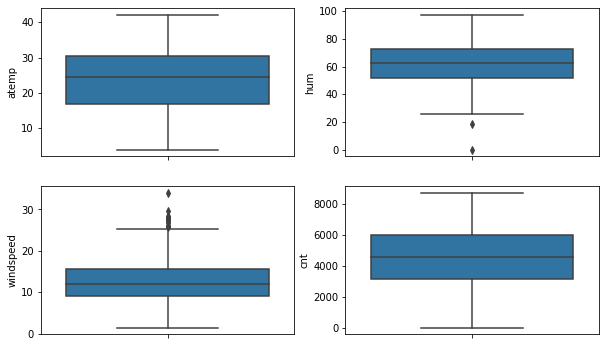

In [21]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
sns.boxplot(y = 'atemp', data = bike_df)
plt.subplot(2,2,2)
sns.boxplot(y = 'hum', data = bike_df)
plt.subplot(2,2,3)
sns.boxplot(y = 'windspeed', data = bike_df)
plt.subplot(2,2,4)
sns.boxplot(y = 'cnt', data = bike_df)
plt.show()

<font color='green'/>**Analysis** - Looks like there are minor outliers in windspeed and hum but they can be ignored

#### Visualising Categorical Variables

As you might have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables.

In [22]:
bike_df.columns
cat_list=['season','yr','month','weekday','weathersit','workingday','holiday']
cat_list

['season', 'yr', 'month', 'weekday', 'weathersit', 'workingday', 'holiday']

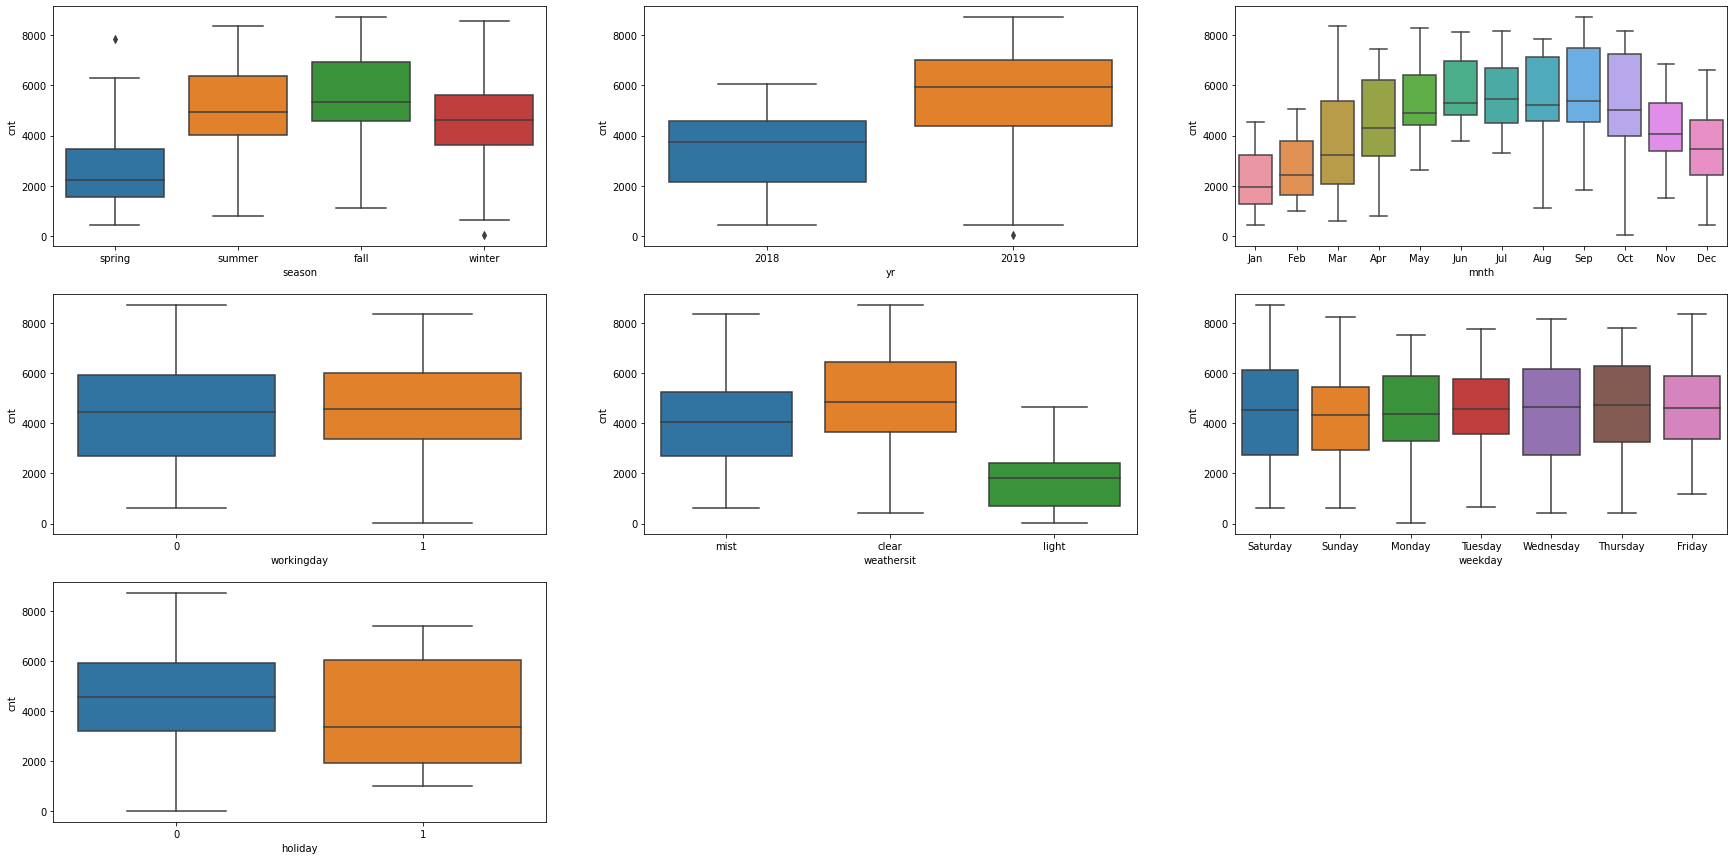

In [23]:
plt.figure(figsize=(30, 15))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike_df)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bike_df)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike_df)
plt.subplot(3,3,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike_df)
plt.subplot(3,3,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike_df)
plt.subplot(3,3,6)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike_df)
plt.subplot(3,3,7)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike_df)
plt.show()

<font color='green'/>**Analysis** - Observations on high rental demand:
1. Season: Summer and Fall
2. Year: 2019 
3. Month: Apr to Oct
4. Weather- Clear
5. Holiday - Less demand on holiday

## Step 3: Data Preparation

In [24]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Saturday,0,mist,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Sunday,0,mist,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Monday,1,clear,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Tuesday,1,clear,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Wednesday,1,clear,11.46350,43.6957,12.522300,1600


### Dummy Variable (Using One Hot Encoder Method)
 Following columns will have dummy variables: season, month,weekday,workingsit

In [25]:
dummy = bike_df[['season','mnth','weekday','weathersit','yr']]
dummy = pd.get_dummies(dummy,drop_first=True)
bike_df = pd.concat([dummy,bike_df],axis = 1)
bike_df.head()

,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,...,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,0,0,1,0,0,0,...,2018,Jan,0,Saturday,0,mist,18.18125,80.5833,10.749882,985
1,1,0,0,0,0,0,1,0,0,0,...,2018,Jan,0,Sunday,0,mist,17.68695,69.6087,16.652113,801
2,1,0,0,0,0,0,1,0,0,0,...,2018,Jan,0,Monday,1,clear,9.47025,43.7273,16.636703,1349
3,1,0,0,0,0,0,1,0,0,0,...,2018,Jan,0,Tuesday,1,clear,10.60610,59.0435,10.739832,1562
4,1,0,0,0,0,0,1,0,0,0,...,2018,Jan,0,Wednesday,1,clear,11.46350,43.6957,12.522300,1600


In [26]:
## dropping columns for which dummy variables were created
bike_df.drop(['season', 'mnth', 'weekday','weathersit','yr'], axis = 1, inplace = True)
bike_df.shape

(730, 29)

In [27]:
bike_metadata=getMetadata(bike_df)
bike_metadata

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
season_spring,uint8,730,0,0.0,2
season_summer,uint8,730,0,0.0,2
season_winter,uint8,730,0,0.0,2
mnth_Aug,uint8,730,0,0.0,2
mnth_Dec,uint8,730,0,0.0,2
mnth_Feb,uint8,730,0,0.0,2
mnth_Jan,uint8,730,0,0.0,2
mnth_Jul,uint8,730,0,0.0,2
mnth_Jun,uint8,730,0,0.0,2
mnth_Mar,uint8,730,0,0.0,2


## Step 4: Splitting the data into training and testing Set
As you know, the first basic step for regression is performing a train-test split.

In [28]:
np.random.seed(0)
df_train, df_test = train_test_split(bike_df, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the features

In [29]:
scaler = MinMaxScaler()

In [30]:
num_vars = ['atemp', 'hum', 'windspeed', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,...,weekday_Wednesday,weathersit_light,weathersit_mist,yr_2019,holiday,workingday,atemp,hum,windspeed,cnt
653,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0.501133,0.575354,0.300794,0.864243
576,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0.766351,0.725633,0.264686,0.827658
426,1,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0.438975,0.640189,0.255342,0.465255
728,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0.200348,0.498067,0.663106,0.204096
482,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0.391735,0.504508,0.188475,0.482973


In [31]:
df_train.describe()

,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,...,weekday_Wednesday,weathersit_light,weathersit_mist,yr_2019,holiday,workingday,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.00000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.243137,0.245098,0.24902,0.096078,0.084314,0.066667,0.088235,0.076471,0.074510,0.098039,...,0.158824,0.029412,0.343137,0.507843,0.025490,0.676471,0.512989,0.650369,0.320768,0.513620
std,0.429398,0.430568,0.43287,0.294988,0.278131,0.249689,0.283915,0.266010,0.262857,0.297660,...,0.365870,0.169124,0.475223,0.500429,0.157763,0.468282,0.212385,0.145882,0.169797,0.224593
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.332086,0.538643,0.199179,0.356420
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.526811,0.653714,0.296763,0.518638
75%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


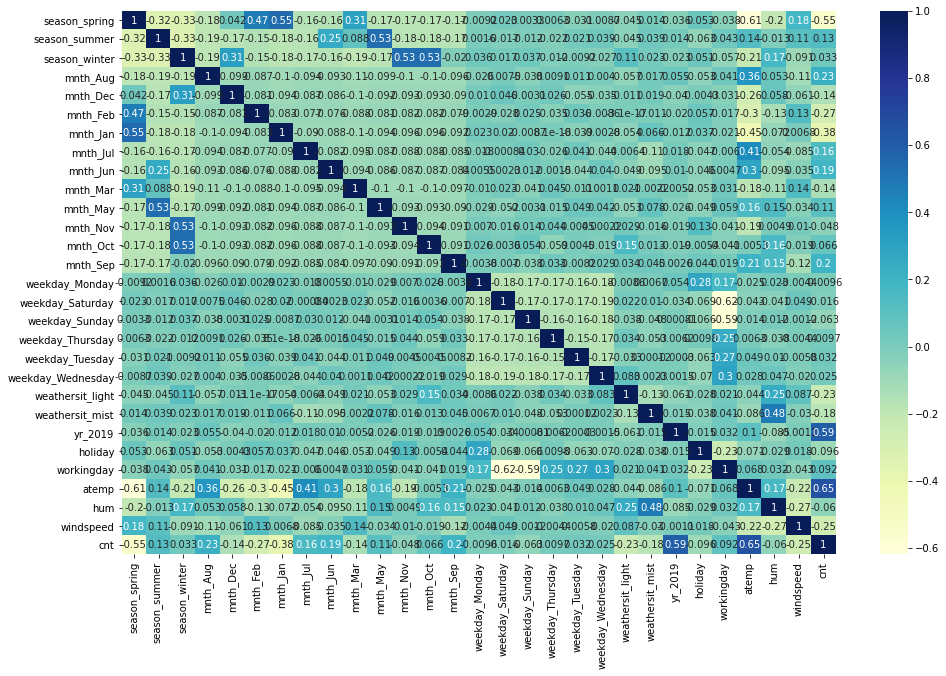

In [32]:
# Let's check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (16, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

<font color='green'/>**Analysis** - Atemp has high correlation with target variable

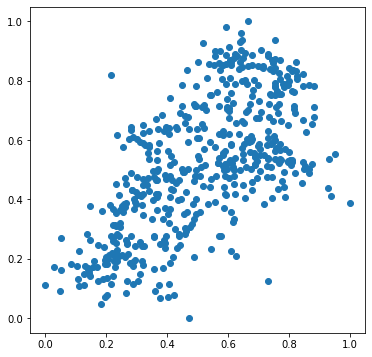

In [33]:
plt.figure(figsize=[6,6])
plt.scatter(df_train.atemp, df_train.cnt)
plt.show()

### Dividing into X and Y sets for the model building

In [34]:
y_train = df_train.pop('cnt')
X_train = df_train

## Step 5: Building the model
### Using RFE for feature selection. Starting with 15 variables

In [35]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [36]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('season_spring', True, 1),
 ('season_summer', False, 6),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 7),
 ('mnth_Dec', False, 2),
 ('mnth_Feb', False, 4),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 9),
 ('mnth_Mar', False, 10),
 ('mnth_May', False, 5),
 ('mnth_Nov', False, 3),
 ('mnth_Oct', False, 13),
 ('mnth_Sep', True, 1),
 ('weekday_Monday', False, 8),
 ('weekday_Saturday', True, 1),
 ('weekday_Sunday', True, 1),
 ('weekday_Thursday', False, 14),
 ('weekday_Tuesday', False, 12),
 ('weekday_Wednesday', False, 11),
 ('weathersit_light', True, 1),
 ('weathersit_mist', True, 1),
 ('yr_2019', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1)]

In [37]:
col = X_train.columns[rfe.support_]
col

Index(['season_spring', 'season_winter', 'mnth_Jan', 'mnth_Jul', 'mnth_Sep',
       'weekday_Saturday', 'weekday_Sunday', 'weathersit_light',
       'weathersit_mist', 'yr_2019', 'holiday', 'workingday', 'atemp', 'hum',
       'windspeed'],
      dtype='object')

In [38]:
X_train.columns[~rfe.support_]

Index(['season_summer', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jun',
       'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'weekday_Monday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics

#### Model Building  Process - 1

In [39]:
X_train_rfe = X_train[col]

In [40]:
X_train_rfe1 = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe1).fit()    # Running the linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          1.66e-188
Time:                        04:19:16   Log-Likelihood:                 510.32
No. Observations:                 510   AIC:                            -990.6
Df Residuals:                     495   BIC:                            -927.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2535      0.026      9.914      0.000       0.203       0.304
season_spring       -0.1043      0.015     -6.858      0.000      -0.134      -0.074
season_winter        0.0458      0.012      3.749      0.000       0.022       0.070
mnth_Jan            -0.0398      0.018     -2.264      0.024      -0.074      -0.005
mnth_Jul            -0.0699      0.017     -4.083      0.000      -0.104      -0.036
mnth_Sep             0.0626      0.015      4.045      0.000       0.032       0.093
weekday_Saturday     0.1066      0.011      9.287      0.000       0.084       0.129
weekday_Sunday       0.0529      0.012      4.385      0.000       0.029       0.077
weathersit_light    -0.2484      0.027     -9.373      0.000      -0.300      -0.196
weathersit_mist     -0.0594      0.011     -5.624      0.000      -0.080      -0.039
yr_2019              0.2325      0.008     28.590      0.000       0.217       0.248
holiday             -0.0025      0.021     -0.117      0.907      -0.045       0.040
workingday           0.0966      0.009     10.325      0.000       0.078       0.115
atemp                0.4761      0.033     14.319      0.000       0.411       0.541
hum                 -0.1449      0.038     -3.824      0.000      -0.219      -0.070
windspeed           -0.1615      0.026     -6.254      0.000      -0.212      -0.111
==============================================================================
Omnibus:                       62.546   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.716
Skew:                          -0.605   Prob(JB):                     2.31e-37
Kurtosis:                       5.544   Cond. No.                     4.94e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.03e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Step 6: Train the model - Reduce the predictors based on VIF and P-Value

#### Model Building Process -2

<font color='green'/>  `holiday` is insignificant in presence of other variables; can be dropped

In [41]:
X_train_rfe = X_train_rfe.drop(["holiday"], axis = 1)

Rebuilding the model without `holiday`

In [42]:
X_train_rfe1 = sm.add_constant(X_train_rfe)
lm_1 = sm.OLS(y_train,X_train_rfe1).fit()    # Running the linear model
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          1.66e-188
Time:                        04:19:16   Log-Likelihood:                 510.32
No. Observations:                 510   AIC:                            -990.6
Df Residuals:                     495   BIC:                            -927.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2510      0.040      6.252      0.000       0.172       0.330
season_spring       -0.1043      0.015     -6.858      0.000      -0.134      -0.074
season_winter        0.0458      0.012      3.749      0.000       0.022       0.070
mnth_Jan            -0.0398      0.018     -2.264      0.024      -0.074      -0.005
mnth_Jul            -0.0699      0.017     -4.083      0.000      -0.104      -0.036
mnth_Sep             0.0626      0.015      4.045      0.000       0.032       0.093
weekday_Saturday     0.1091      0.027      4.010      0.000       0.056       0.163
weekday_Sunday       0.0554      0.027      2.024      0.043       0.002       0.109
weathersit_light    -0.2484      0.027     -9.373      0.000      -0.300      -0.196
weathersit_mist     -0.0594      0.011     -5.624      0.000      -0.080      -0.039
yr_2019              0.2325      0.008     28.590      0.000       0.217       0.248
workingday           0.0991      0.026      3.848      0.000       0.048       0.150
atemp                0.4761      0.033     14.319      0.000       0.411       0.541
hum                 -0.1449      0.038     -3.824      0.000      -0.219      -0.070
windspeed           -0.1615      0.026     -6.254      0.000      -0.212      -0.111
==============================================================================
Omnibus:                       62.546   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.716
Skew:                          -0.605   Prob(JB):                     2.31e-37
Kurtosis:                       5.544   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<font color='green'/>**Analysis** - All the predictors have p-value < 0.05. Hence checking the VIF for mutlicollinearity

In [43]:
vif=getVIF(X_train_rfe)
vif

,Features,VIF
12,hum,29.98
11,atemp,18.21
10,workingday,17.13
5,weekday_Saturday,4.62
13,windspeed,4.51
6,weekday_Sunday,4.49
0,season_spring,3.05
8,weathersit_mist,2.28
1,season_winter,2.11
9,yr_2019,2.08


<font color='green'/>**Analysis** - 
We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

### Dropping the variable and updating the model

As you can see from the summary and the VIF dataframe, some variables are still insignificant. One of these variables is, `hum` as it has a very high VIF of `29.98`. Let's go ahead and drop this variables

#### Model Building Process - 3

In [44]:
X_train_rfe=X_train_rfe.drop(['hum'],axis=1)

In [45]:
X_train_rfe1 = sm.add_constant(X_train_rfe)
lm_2 = sm.OLS(y_train,X_train_rfe1).fit()    # Running the linear model
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.6
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          1.51e-186
Time:                        04:19:16   Log-Likelihood:                 502.89
No. Observations:                 510   AIC:                            -977.8
Df Residuals:                     496   BIC:                            -918.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1745      0.035      4.946      0.000       0.105       0.244
season_spring       -0.1071      0.015     -6.957      0.000      -0.137      -0.077
season_winter        0.0369      0.012      3.038      0.003       0.013       0.061
mnth_Jan            -0.0437      0.018     -2.457      0.014      -0.079      -0.009
mnth_Jul            -0.0627      0.017     -3.632      0.000      -0.097      -0.029
mnth_Sep             0.0595      0.016      3.801      0.000       0.029       0.090
weekday_Saturday     0.1115      0.028      4.045      0.000       0.057       0.166
weekday_Sunday       0.0533      0.028      1.924      0.055      -0.001       0.108
weathersit_light    -0.2888      0.025    -11.722      0.000      -0.337      -0.240
weathersit_mist     -0.0827      0.009     -9.456      0.000      -0.100      -0.065
yr_2019              0.2360      0.008     28.815      0.000       0.220       0.252
workingday           0.0999      0.026      3.826      0.000       0.049       0.151
atemp                0.4443      0.033     13.615      0.000       0.380       0.508
windspeed           -0.1358      0.025     -5.373      0.000      -0.185      -0.086
==============================================================================
Omnibus:                       65.217   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.625
Skew:                          -0.643   Prob(JB):                     1.47e-37
Kurtosis:                       5.515   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<font color='green'/>**Analysis** - From the above observations, we see that the p-values of all features are under control. So we will proceed ahead to VIF table

In [46]:
vif=getVIF(X_train_rfe)
vif

,Features,VIF
10,workingday,13.71
11,atemp,12.74
12,windspeed,4.50
5,weekday_Saturday,3.90
6,weekday_Sunday,3.66
0,season_spring,2.81
9,yr_2019,2.07
1,season_winter,1.75
2,mnth_Jan,1.65
8,weathersit_mist,1.58



In the VIF table, we see that `workingday`seems to be explained by some other feature. So we will again drop this  feature and design our model.

### Dropping the variable and updating the model
#### Model Building Process -4 

In [47]:
X_train_rfe=X_train_rfe.drop(['workingday'],axis=1)

In [48]:
X_train_rfe1 = sm.add_constant(X_train_rfe)
lm_3 = sm.OLS(y_train,X_train_rfe1).fit()    # Running the linear model
lm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     207.1
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          1.35e-184
Time:                        04:19:16   Log-Likelihood:                 495.47
No. Observations:                 510   AIC:                            -964.9
Df Residuals:                     497   BIC:                            -909.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2710      0.025     10.839      0.000       0.222       0.320
season_spring       -0.1094      0.016     -7.019      0.000      -0.140      -0.079
season_winter        0.0340      0.012      2.761      0.006       0.010       0.058
mnth_Jan            -0.0445      0.018     -2.465      0.014      -0.080      -0.009
mnth_Jul            -0.0622      0.017     -3.555      0.000      -0.097      -0.028
mnth_Sep             0.0558      0.016      3.522      0.000       0.025       0.087
weekday_Saturday     0.0155      0.012      1.339      0.181      -0.007       0.038
weekday_Sunday      -0.0426      0.012     -3.562      0.000      -0.066      -0.019
weathersit_light    -0.2842      0.025    -11.396      0.000      -0.333      -0.235
weathersit_mist     -0.0808      0.009     -9.131      0.000      -0.098      -0.063
yr_2019              0.2365      0.008     28.487      0.000       0.220       0.253
atemp                0.4461      0.033     13.487      0.000       0.381       0.511
windspeed           -0.1379      0.026     -5.382      0.000      -0.188      -0.088
==============================================================================
Omnibus:                       80.014   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.019
Skew:                          -0.762   Prob(JB):                     3.73e-49
Kurtosis:                       5.859   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<font color='green'/>**Analysis** - In the above model we see that P-Value of `weekday_Saturday` feature is more than 0.05, which make its co-efficient insignificant.
So, we will proceed ahead with dropping this feature and designing model again.


### Dropping the variable and updating the model
#### Model Building Process -5 

In [49]:
X_train_rfe=X_train_rfe.drop(['weekday_Saturday'],axis=1)

In [50]:
X_train_rfe1 = sm.add_constant(X_train_rfe)
lm_4 = sm.OLS(y_train,X_train_rfe1).fit()    # Running the linear model
lm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     225.5
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          2.14e-185
Time:                        04:19:16   Log-Likelihood:                 494.56
No. Observations:                 510   AIC:                            -965.1
Df Residuals:                     498   BIC:                            -914.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2738      0.025     10.979      0.000       0.225       0.323
season_spring       -0.1094      0.016     -7.012      0.000      -0.140      -0.079
season_winter        0.0343      0.012      2.786      0.006       0.010       0.058
mnth_Jan            -0.0443      0.018     -2.453      0.014      -0.080      -0.009
mnth_Jul            -0.0616      0.017     -3.519      0.000      -0.096      -0.027
mnth_Sep             0.0559      0.016      3.523      0.000       0.025       0.087
weekday_Sunday      -0.0455      0.012     -3.855      0.000      -0.069      -0.022
weathersit_light    -0.2841      0.025    -11.379      0.000      -0.333      -0.235
weathersit_mist     -0.0807      0.009     -9.121      0.000      -0.098      -0.063
yr_2019              0.2361      0.008     28.437      0.000       0.220       0.252
atemp                0.4452      0.033     13.452      0.000       0.380       0.510
windspeed           -0.1364      0.026     -5.324      0.000      -0.187      -0.086
==============================================================================
Omnibus:                       75.505   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.812
Skew:                          -0.707   Prob(JB):                     3.06e-48
Kurtosis:                       5.881   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<font color='green'/>**Analysis** - From the above observations, we see that the p-values of all features are under control. So we will proceed ahead to VIF table

In [51]:
vif=getVIF(X_train_rfe)
vif

,Features,VIF
9,atemp,4.60
10,windspeed,3.91
0,season_spring,2.24
8,yr_2019,2.06
2,mnth_Jan,1.60
7,weathersit_mist,1.53
1,season_winter,1.40
3,mnth_Jul,1.35
4,mnth_Sep,1.20
5,weekday_Sunday,1.17


<font color='green'/>**Analysis** - From the Model Summary Report we can say that all the p-values of respective features are well under control
Note: It is a hurestic approach that, if VIF value of any predictor is between 5 & 10, it is recommended to scrutinize such variable from business perspective and analyse any outliers & drop such feature if VIF is greater than 10
We see that all the features under VIF table are well under control, so we can fix the features available for our model

## Step 7: Residual Analysis of the train data

### 1. Error Term Distribution

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

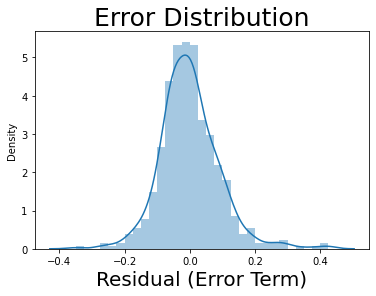

In [52]:
y_train_pred = lm_4.predict(X_train_rfe1)
residual = y_train_pred - y_train
sns.distplot(residual)
plt.xlabel('Residual (Error Term)', fontdict={'fontsize': 20})
plt.title('Error Distribution', fontdict={'fontsize': 25})
plt.show()

<font color='green'/>**Analysis** - From the above graph it is evident that Error Distribution Is Normallly Distributed Across 0, which indicates that our model has handled the assumption of Error Normal Distribution properly.

### 2. Assumption of Error Terms Being Independent

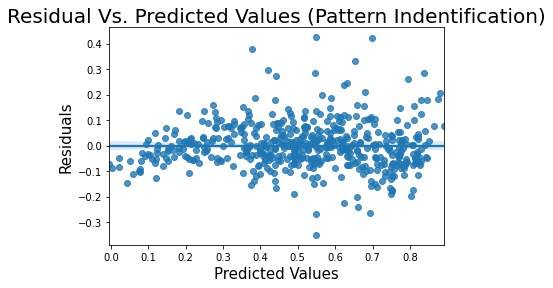

In [53]:
sns.regplot(x=y_train_pred, y=residual)
plt.title('Residual Vs. Predicted Values (Pattern Indentification)', fontdict={'fontsize': 20})
plt.xlabel('Predicted Values', fontdict={'fontsize': 15})
plt.ylabel('Residuals', fontdict={'fontsize': 15})
plt.show()

### 3. Pearson's Correlation

In [54]:
print("Pearson Value for Predicted Value Against Residual ==>", pearsonr(y_train_pred, residual)[0])

Pearson Value for Predicted Value Against Residual ==> 5.129143637594424e-15


<font color='green'/>**Analysis** - From the above graph, we see that there is almost no relation between Residual & Predicted Value. This is what we had expected from our model to have no specific pattern.

### 4. Homoscedasticity

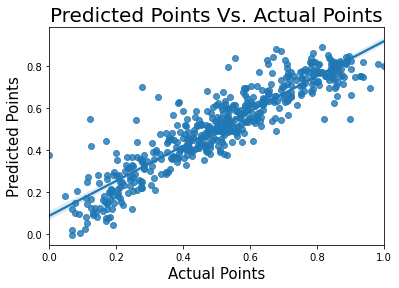

In [55]:
sns.regplot(x=y_train, y=y_train_pred)
plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
plt.show()

<font color='green'/>**Analysis** - From the above graph, we can say that residuals are equal distributed across predicted value.
This means we see equal variance and we do NOT observe high concentration of data points in certain region & low conecentarion in certain regions.
This proves Homoscedasticity of Error Terms

### 5. Multicorrelation
This asumption is already taken care of while building model by calculating VIF of evry predictor. Following is the final VIF value of all the predictors used in the model

In [56]:
vif=getVIF(X_train_rfe)
vif

,Features,VIF
9,atemp,4.60
10,windspeed,3.91
0,season_spring,2.24
8,yr_2019,2.06
2,mnth_Jan,1.60
7,weathersit_mist,1.53
1,season_winter,1.40
3,mnth_Jul,1.35
4,mnth_Sep,1.20
5,weekday_Sunday,1.17


## Step 8: Making Predictions Using the final model on test data

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fourth model (lm_4)
#### Applying the scaling on the test sets

In [57]:
num_vars = ['atemp', 'hum', 'windspeed', 'cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [58]:
df_test.describe()

,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,...,weekday_Wednesday,weathersit_light,weathersit_mist,yr_2019,holiday,workingday,atemp,hum,windspeed,cnt
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.255708,0.264840,0.232877,0.059361,0.086758,0.100457,0.077626,0.105023,0.095890,0.054795,...,0.100457,0.027397,0.319635,0.479452,0.036530,0.698630,0.532991,0.638508,0.313350,0.520592
std,0.437258,0.442259,0.423633,0.236840,0.282125,0.301297,0.268194,0.307285,0.295115,0.228100,...,0.301297,0.163612,0.467403,0.500722,0.188034,0.459904,0.217888,0.148974,0.159947,0.218435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025950,0.261915,-0.042808,0.048205
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.344751,0.527265,0.198517,0.377531
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.549198,0.627737,0.299459,0.524275
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.714132,0.743928,0.403048,0.672745
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.980934,1.002146,0.807474,0.963300


#### Dividing into X_test and y_test

In [59]:
y_test = df_test.pop('cnt')
X_test = df_test

In [60]:
# Now let's use our model to make predictions.
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_rfe.columns]
# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [61]:
# Making predictions
y_pred = lm_4.predict(X_test_new)

## Step 9: Model Evaluation
Let's now plot the graph for actual versus predicted values.

In [62]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.09579435931977502

In [63]:
r_squared = r2_score(y_test, y_pred)
round(r_squared,4)

0.8068

<font color='green'/>**Analysis** - Not a significant difference b/w R-Square value b/w train and test data `(0.833 vs 0.8068)`

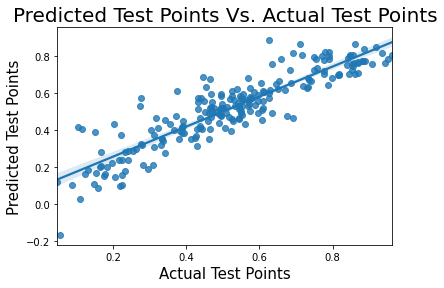

In [64]:
# Plotting y_test and y_pred to understand the spread
corr_plot = sns.regplot(x=y_test, y=y_pred)
plt.title('Predicted Test Points Vs. Actual Test Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Test Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Test Points', fontdict={'fontsize': 15})
plt.show()

We can see that the equation of our best fitted line is:

$ cnt = 0.2738 - 0.1094 \times  season_spring + 0.0343 \times season_winter - 0.0443 \times mnth_Jan -0.0616 \times mnth_Jul + 0.0559 \times mnth_Sep -0.0455 \times weekday_Sunday -0.2841 \times weathersit_light -0.0807 \times weathersit_mist + 0.2361 \times yr_2019 + 0.4452 \times atemp -0.1364 \times windspeed $